In [47]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer as cv, TfidfTransformer as tfidf
import contractions
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.corpus import wordnet
from sklearn.naive_bayes import MultinomialNB
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv("./data.csv")

### Basic data analysis

In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df.head()

,Questions,Category0,Category1,Category2
0,How did serfdom develop in and then leave Russ...,DESCRIPTION,DESC,manner
1,What films featured the character Popeye Doyle ?,ENTITY,ENTY,cremat
2,How can I find a list of celebrities ' real na...,DESCRIPTION,DESC,manner
3,What fowl grabs the spotlight after the Chines...,ENTITY,ENTY,animal
4,What is the full form of .com ?,ABBREVIATION,ABBR,exp


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  5452 non-null   object
 1   Category0  5452 non-null   object
 2   Category1  5452 non-null   object
 3   Category2  5452 non-null   object
dtypes: object(4)
memory usage: 170.5+ KB


In [6]:
# count of target categories
print("Category type 0: \n", df["Category0"].nunique(), df["Category0"].unique())
print("Category type 1: \n", df["Category1"].nunique(), df["Category1"].unique())
print("Category type 2: \n", df["Category2"].nunique(), df["Category2"].unique())

Category type 0: 
 6 ['DESCRIPTION' 'ENTITY' 'ABBREVIATION' 'HUMAN' 'NUMERIC' 'LOCATION']
Category type 1: 
 6 ['DESC' 'ENTY' 'ABBR' 'HUM' 'NUM' 'LOC']
Category type 2: 
 47 ['manner' 'cremat' 'animal' 'exp' 'ind' 'gr' 'title' 'def' 'date' 'reason'
 'event' 'state' 'desc' 'count' 'other' 'letter' 'religion' 'food'
 'country' 'color' 'termeq' 'city' 'body' 'dismed' 'mount' 'money'
 'product' 'period' 'substance' 'sport' 'plant' 'techmeth' 'volsize'
 'instru' 'abb' 'speed' 'word' 'lang' 'perc' 'code' 'dist' 'temp' 'symbol'
 'ord' 'veh' 'weight' 'currency']


In [7]:
# category 0 and category 1 are same, drop any 1
df.drop("Category1", axis=1, inplace=True)
df = df.rename(columns={"Category0": "Major", "Category2": "Minor"})

In [8]:
df.head()

,Questions,Major,Minor
0,How did serfdom develop in and then leave Russ...,DESCRIPTION,manner
1,What films featured the character Popeye Doyle ?,ENTITY,cremat
2,How can I find a list of celebrities ' real na...,DESCRIPTION,manner
3,What fowl grabs the spotlight after the Chines...,ENTITY,animal
4,What is the full form of .com ?,ABBREVIATION,exp


In [9]:
# groupby category 0 to organise category 1
df.groupby('Minor')["Major"].value_counts()

Minor      Major       
abb        ABBREVIATION     16
animal     ENTITY          112
body       ENTITY           16
city       LOCATION        129
code       NUMERIC           9
color      ENTITY           40
count      NUMERIC         363
country    LOCATION        155
cremat     ENTITY          207
currency   ENTITY            4
date       NUMERIC         218
def        DESCRIPTION     421
desc       DESCRIPTION     274
           HUMAN            47
dismed     ENTITY          103
dist       NUMERIC          34
event      ENTITY           56
exp        ABBREVIATION     70
food       ENTITY          103
gr         HUMAN           189
ind        HUMAN           962
instru     ENTITY           10
lang       ENTITY           16
letter     ENTITY            9
manner     DESCRIPTION     276
money      NUMERIC          71
mount      LOCATION         21
ord        NUMERIC           6
other      LOCATION        464
           ENTITY          217
           NUMERIC          52
perc       NUME

<AxesSubplot:ylabel='Major'>

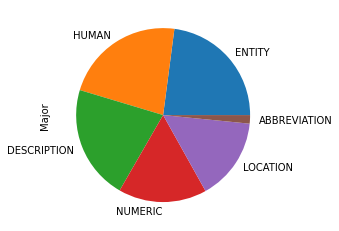

In [10]:
df.Major.value_counts(normalize=True).plot(kind="pie")

1. There are 5452 records
2. The major target has 6 different categories
3. The minor target has 47 different categories
4. The number of samples for the major class "ABBREVIATION" is much lower as compared to the number of samples for other major classes
5. 2 minor classes - "other" and "desc" belong to more than one major classes. The other minor classes are unique to major classes. 

In [11]:
df["Questions"]

0       How did serfdom develop in and then leave Russ...
1        What films featured the character Popeye Doyle ?
2       How can I find a list of celebrities ' real na...
3       What fowl grabs the spotlight after the Chines...
4                         What is the full form of .com ?
                              ...                        
5447              What 's the shape of a camel 's spine ?
5448             What type of currency is used in China ?
5449                      What is the temperature today ?
5450                What is the temperature for cooking ?
5451                 What currency is used in Australia ?
Name: Questions, Length: 5452, dtype: object

### Text pre-processing
1. The Questions text contain contractions. The contractions are separated by space, which is not usual. 
example: What 's the shape of a camel 's spine ?

a. We have to fix the additional space in between

b. We can attempt to normalize the contractions

2. We can normalize the words by lemmatizing
3. We can then remove the additional punctuations and only retain the valid words 
4. We can then count the frequency of words and use the most frequent prepositions as stopword filter

We have to generate the stop words.

Steps 3 and 4 can be done by the CountVectorizer.


In [12]:
# attempt to get the stopwords
# stop words have a very high frequency
def pre_process(text):
    # step 1
    text = re.sub(r"\w+\s\'s", lambda x: "".join(x[0].split()), text)
    text = re.sub(r"\w+\s\'t", lambda x: "".join(x[0].split()), text)
    text = contractions.fix(text)
    return text
df["Questions_p1"] = df["Questions"].apply(lambda x: pre_process(x))

In [13]:
lemmatizer = WordNetLemmatizer()
 
def lemmatize_text(text):
    ## referenced from geek for geeks:
    ## https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
    # Define function to lemmatize each word with its POS tag

    # POS_TAGGER_FUNCTION : TYPE 1
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None

    # tokenize the sentence and find the POS tag for each token
#     pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
    pos_tagged = nltk.pos_tag(text.split()) 
    
    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


In [14]:
df['Questions_p2'] = df["Questions_p1"].apply(lambda x: lemmatize_text(x))

In [15]:
df.head(20)

,Questions,Major,Minor,Questions_p1,Questions_p2
0,How did serfdom develop in and then leave Russ...,DESCRIPTION,manner,How did serfdom develop in and then leave Russ...,How do serfdom develop in and then leave Russia ?
1,What films featured the character Popeye Doyle ?,ENTITY,cremat,What films featured the character Popeye Doyle ?,What film feature the character Popeye Doyle ?
2,How can I find a list of celebrities ' real na...,DESCRIPTION,manner,How can I find a list of celebrities ' real na...,How can I find a list of celebrity ' real name ?
3,What fowl grabs the spotlight after the Chines...,ENTITY,animal,What fowl grabs the spotlight after the Chines...,What fowl grab the spotlight after the Chinese...
4,What is the full form of .com ?,ABBREVIATION,exp,What is the full form of .com ?,What be the full form of .com ?
5,What contemptible scoundrel stole the cork fro...,HUMAN,ind,What contemptible scoundrel stole the cork fro...,What contemptible scoundrel steal the cork fro...
6,What team did baseball 's St. Louis Browns bec...,HUMAN,gr,What team did baseball's St. Louis Browns beco...,What team do baseball's St. Louis Browns become ?
7,What is the oldest profession ?,HUMAN,title,What is the oldest profession ?,What be the old profession ?
8,What are liver enzymes ?,DESCRIPTION,def,What are liver enzymes ?,What be liver enzyme ?
9,Name the scar-faced bounty hunter of The Old W...,HUMAN,ind,Name the scar-faced bounty hunter of The Old W...,Name the scar-faced bounty hunter of The Old W...


In [16]:
text = df["Questions_p2"].apply(lambda x: x.lower()).to_list()

In [17]:
text_new = []
for s in text:
    text_new.extend(s.split())
result = Counter(text_new)
# print(result)

In [18]:
# deriving the custom set of stopwords from the counter results
# certain words, which are tempting to be used as stopwords, might actually be useful for classifying the question
# punctuations are removed by default in the CountVectorizer
custom_stopwords_list = ["the", "is", "of", "in", "a", "was", "to", "are", "for", "and", "does", "did", "do", "on", "an", "at"]

In [19]:
# prepare the basic pipeline
nb_pipe = make_pipeline(cv(analyzer="word", lowercase=True, stop_words=custom_stopwords_list), MultinomialNB())

### Train-Test Split and Base Model

In [20]:
X = df["Questions_p2"]
y = df["Major"]

In [25]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

In [27]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [28]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

4361 1091 4361 1091


In [32]:
y_train.value_counts(normalize=True)

ENTITY          0.229305
HUMAN           0.224260
DESCRIPTION     0.213025
NUMERIC         0.164412
LOCATION        0.153176
ABBREVIATION    0.015822
Name: Major, dtype: float64

In [33]:
y_test.value_counts(normalize=True)

ENTITY          0.229148
HUMAN           0.224565
DESCRIPTION     0.213566
NUMERIC         0.164070
LOCATION        0.153071
ABBREVIATION    0.015582
Name: Major, dtype: float64

In [35]:
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['the', 'is', 'of', 'in', 'a',
                                             'was', 'to', 'are', 'for', 'and',
                                             'does', 'did', 'do', 'on', 'an',
                                             'at'])),
                ('multinomialnb', MultinomialNB())])

In [37]:
y_pred = nb_pipe.predict(X_test)

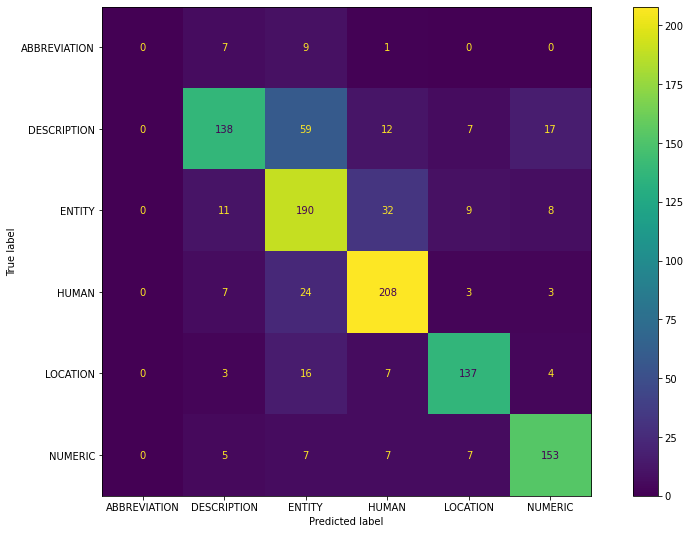

In [43]:
from pylab import rcParams
rcParams["figure.figsize"] = 15,9
ConfusionMatrixDisplay.from_estimator(nb_pipe, X_test, y_test)

In [46]:
print(classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

ABBREVIATION       0.00      0.00      0.00        17
 DESCRIPTION       0.81      0.59      0.68       233
      ENTITY       0.62      0.76      0.68       250
       HUMAN       0.78      0.85      0.81       245
    LOCATION       0.84      0.82      0.83       167
     NUMERIC       0.83      0.85      0.84       179

    accuracy                           0.76      1091
   macro avg       0.65      0.65      0.64      1091
weighted avg       0.75      0.76      0.75      1091



C:\Users\003BY4744\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\003BY4744\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\003BY4744\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
